In [65]:
import numpy as np
import pandas as pd
import os
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
from collections import OrderedDict

In [66]:
from platform import python_version
print(python_version())

3.6.6


### Create edgelist using events data

In [67]:
event_file = [item for item in os.listdir('../../data/protag_events_nogen/') if 'txt' in item]

In [69]:
events_all = []
cnt = 0
for name in event_file:
    movie_events = []
    with open(os.path.join('../../data/protag_events_nogen/', name), 'r') as f:
        lines = [line.strip() for line in f.readlines()]
        for line in lines:
            line = line.split(' ')
            movie_events.append(line[1].split('-')[0])
        events_all.append(movie_events)


In [70]:
len(events_all)

13055

In [204]:
def build_edgelist(events_all=events_all, use_top_nodes=False, top_events=None ):
    edgelist = []
    if use_top_nodes == False:
        for movie_event in events_all:
            for i in range(len(movie_event)-1):
                 edgelist.append((movie_event[i], movie_event[i+1]))
    else:
        events_all_flt = []
        for item in events_all:
            events_all_flt.extend(item)
        c = Counter(events_all_flt)
        top_events = set([item[0] for item in c.most_common(top_events)])
        for movie_event in events_all:
            for i in range(len(movie_event)-1):
        #         only use the most frequent x events
                if movie_event[i] in top_events and movie_event[i+1] in top_events:
                    edgelist.append((movie_event[i], movie_event[i+1]))
    return edgelist

In [205]:
edgelist = build_edgelist(events_all)

False


In [158]:
def build_wtd_edgelist(edgelist, k=1):
    edgelist_wtd = []
    c = Counter(edgelist)
    for item in edgelist:
        if c[item] > k:
            edge = (item[0], item[1], c[item])
            edgelist_wtd.append(edge)
    return edgelist_wtd

In [212]:
edgelist_wtd = build_wtd_edgelist(edgelist)

### Build networkX network

In [213]:
G = nx.DiGraph()

In [214]:
G.add_weighted_edges_from(edgelist_wtd)

In [215]:
G.number_of_nodes()

2026

In [216]:
G.number_of_edges()

29509

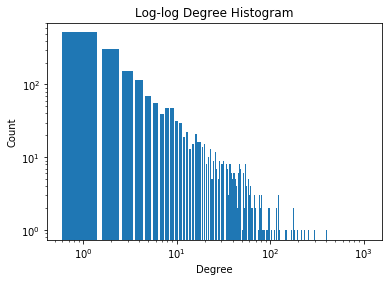

In [81]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCount = Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt)

plt.title("Log-log Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.xscale('log')
plt.yscale('log')
# ax.set_xticks([d + 0.4 for d in deg])
# ax.set_xticklabels(deg)

In [211]:
nx.write_gml(G, 'event_network_5core_nogen.gml')

### Backbone extraction

In [217]:
from backbone import disparity_filter, disparity_filter_alpha_cut

In [218]:
G_c = disparity_filter(G)

In [219]:
G_c.number_of_nodes()

2026

In [223]:
C = disparity_filter_alpha_cut(G_c,weight='weight', alpha_t = 0.3)

In [224]:
C.number_of_edges()

7488

In [225]:
C.number_of_nodes()

908

In [226]:
nx.write_gml(C, 'event_network_backbone_nogen.gml')

In [227]:
nx.__version__

'2.2'

### Event transitions

In [170]:
df = pd.DataFrame.from_records(edgelist_wtd, columns = ['src', 'des', 'weight'])

In [171]:
df.head(2)

,src,des,weight
0,confronts,manages,8
1,come,arrives,4


Normalize by the method used in the linkedin paper. From that paper:


The expected flux between $i$ and $j$ is estimated by 
%
\begin{equation} 
%
\mathop{\mathbb{E}}(w_{i\rightarrow j}) = S^{\mathrm{out}}_i \frac{S^{\mathrm{in}}_j}{\sum_k S^{\mathrm{in}}_k},
%
\end{equation}
%
where $S^{\mathrm{out}}$ is the total number of members who 
moved out of $i$, and $ S^{\mathrm{in}}_j$ is the total number of members that
moved into $j$. 
Thus the normalized flux from $i$ to $j$ is estimated by
%
\begin{equation} T_{i\rightarrow j} = \frac{w_{i\rightarrow
j}}{\mathop{\mathbb{E}}(w_{i\rightarrow j})}. \end{equation}
%
As a result, we have $T_{i\rightarrow j}>1$ if there are more people moving
from $i$ to $j$ than expected by the given null model, and  $T_{i\rightarrow
j}<1$ vice versa. 


In [172]:
# Compute Size of Each event as source (S_i out)
s_src = df.groupby('src', as_index=False).agg({'weight': np.sum})
s_src.columns = ['src_event', 'size']

In [173]:
s_src.head(2)

,src_event,size
0,accepts,1523
1,admits,761


In [174]:
# Compute Size of Each event as destination (S_i in)
s_des = df.groupby('des', as_index=False).agg({'weight': np.sum})
s_des.columns = ['des_event', 'size']

In [175]:
s_des.head(2)

,des_event,size
0,accepts,1215
1,admits,846


In [176]:
expected = pd.merge(df, s_src, left_on='src', right_on = 'src_event')

In [177]:
expected.head(2)

,src,des,weight,src_event,size
0,confronts,manages,8,confronts,3698
1,confronts,kills,13,confronts,3698


In [178]:
expected = pd.merge(expected, s_des, left_on='des', right_on='des_event', suffixes=['_src', '_des'])

In [179]:
len(expected)

50315

In [180]:
expected['exp'] = expected['size_src']*expected['size_des']/sum(expected['size_des']) # Sum of all in weights
expected['normed_weight'] = expected['weight']/expected['exp'] # Normalized = actual weight/expected weight
expected = expected[['src', 'des', 'normed_weight']]

In [181]:
expected = expected.drop_duplicates()

In [182]:
expected.head(2)

,src,des,normed_weight
0,confronts,manages,3837.067581
8,come,manages,4859.409560


In [183]:
len(expected)

6639

In [184]:
df = expected

### Hierarchical clustering

In [185]:
df = df.pivot(index="src", columns="des", values='normed_weight')
df.fillna(1.0, inplace=True)
df = np.log(df)

In [186]:
df.head()

des,accepts,admits,agrees,appears,arrives,asks,attempts,become,becomes,begins,...,thinks,throws,told,tries,try,turns,uses,wakes,walks,wants
src,,,,,,,,,,,,,,,,,,,,,
accepts,11.040022,0.000000,8.162628,0.000000,0.000000,6.574117,0.000000,0.000000,7.317795,7.827995,...,0.0,0.000000,8.842248,6.640060,0.000000,0.000000,8.093419,0.0,0.000000,7.847836
admits,0.000000,11.536190,8.856432,0.000000,0.000000,7.778746,8.789646,0.000000,7.675127,0.000000,...,0.0,0.000000,0.000000,7.557008,0.000000,9.824801,0.000000,0.0,0.000000,8.541640
agrees,0.000000,7.951941,8.124815,8.140809,7.265231,5.917264,7.507983,6.351527,5.477172,6.477995,...,0.0,7.421452,7.743563,6.582829,7.246459,0.000000,7.687881,0.0,6.963605,6.566829
appears,0.000000,0.000000,7.639599,11.319154,7.399055,7.149700,7.978278,0.000000,6.640615,7.528109,...,0.0,0.000000,0.000000,7.082112,0.000000,8.725751,9.074467,0.0,8.350191,0.000000
arrives,0.000000,7.780885,6.081956,0.000000,7.738532,5.959782,7.519248,5.957327,4.900651,5.901474,...,0.0,7.943543,7.860189,5.945682,7.363085,6.762643,6.705894,0.0,7.080230,0.000000


In [187]:
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
import seaborn as sns


In [188]:

method = 'average'
metric = 'euclidean'
Z = hierarchy.linkage(df, method=method, metric=metric)
# c, coph_dists = hierarchy.cophenet(Z, pdist(df))
# part = hierarchy.fclusterdata(Z,1.5)

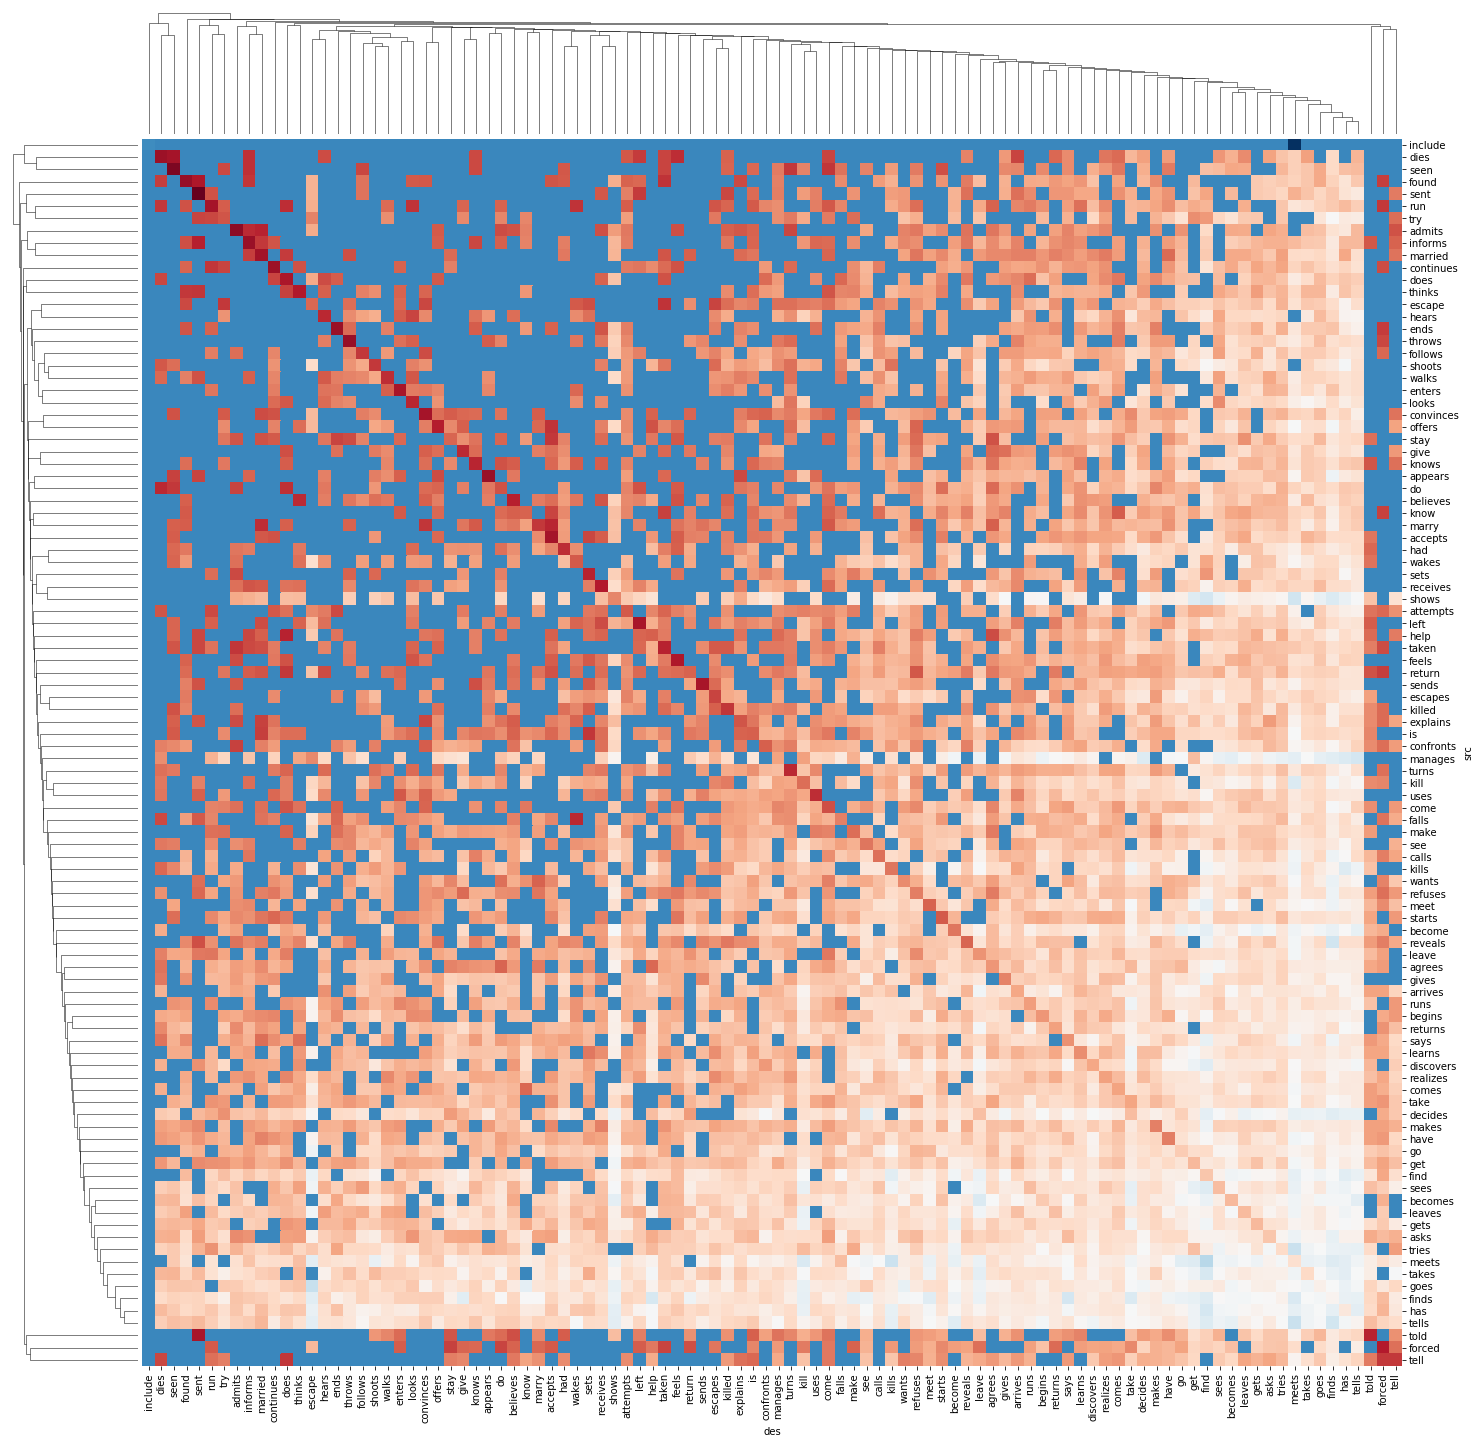

In [190]:
cm = sns.clustermap(df,figsize=(25, 25),row_linkage=Z, col_linkage=Z, cmap = "RdBu_r")#, xticklabels = False, yticklabels = False)
cm.cax.set_visible(False)

plt.savefig('cluster_top_events_nogen.pdf', format='pdf')